In [1]:
import pandas as pd
import numpy as np

file_path = '/Users/aaryanshah/Oncampus-Job/NLP_Gal/clustering/Updated_Clusters.csv'
data = pd.read_csv(file_path)

print(data.head())


  Core (Products) Core (Chemicals) Core (Support Activities) Core (Logistics)  \
0           Crude          plastic                production      warehousing   
1           Shale    polypropylene               manufacture   transportation   
2     Hydrocarbon     polyethylene                   produce          vehicle   
3         Methane          polymer              construction        transport   
4       Petroleum        propylene               distributor       automotive   

  Core (Retail) Core (Processes) Core (Infrastructure)  \
0        retail         Refinery              Pipeline   
1      retailer     Gasification              Oilfield   
2   supermarket     Distillation              pipeline   
3          shop         Cracking                  pipe   
4      shopping           Coking                   rig   

  Core (Energy & Utility Terms) Emerging (Renewables) Emerging (Bio-Energy)  \
0                    Combustion                 solar               biofuel   
1     

In [2]:

words = []
labels = []

for column in data.columns:
    words.extend(data[column].dropna().tolist())
    labels.extend([column] * data[column].dropna().size)

print(f"Total words extracted: {len(words)}")
print(f"Unique labels (clusters): {set(labels)}")


Total words extracted: 671
Unique labels (clusters): {'Emerging (Bio-Energy)', 'Core (Logistics)', 'Emerging (Unrelated)', 'Core (Energy & Utility Terms)', 'Core (Products)', 'Core (Processes)', 'Core (Infrastructure)', 'Core (Retail)', 'Core (Chemicals)', 'Emerging (Renewables)', 'Core (Support Activities)'}


In [3]:
from transformers import BertModel, BertTokenizer
import torch

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()

# Function to get BERT embeddings for a list of words
def get_bert_embeddings(words):
    marked_texts = ["[CLS] " + word + " [SEP]" for word in words]
    tokenized_texts = [tokenizer.tokenize(text) for text in marked_texts]
    indexed_tokens = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts]
    segments_ids = [[1] * len(txt) for txt in tokenized_texts]

    # Convert inputs to PyTorch tensors
    tokens_tensors = [torch.tensor([tokens]) for tokens in indexed_tokens]
    segments_tensors = [torch.tensor([segments]) for segments in segments_ids]

    # Predict hidden states features for each layer
    embeddings = []
    with torch.no_grad():
        for i in range(len(tokens_tensors)):
            outputs = model(tokens_tensors[i], segments_tensors[i])
            hidden_states = outputs[2]
            token_vecs = hidden_states[-2][0]  # Second to last layer
            sentence_embedding = torch.mean(token_vecs, dim=0)
            embeddings.append(sentence_embedding.numpy())

    return np.array(embeddings)

# Flatten the data frame to a list of words with their cluster labels
words = []
labels = []
for column in data.columns:
    clean_words = [word for word in data[column].dropna().tolist()]
    words.extend(clean_words)
    labels.extend([column] * len(clean_words))

# Generate BERT embeddings
word_embeddings = get_bert_embeddings(words)

word_embeddings.shape  # Check the shape of the embeddings matrix


/Users/aaryanshah/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/aaryanshah/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be re

(671, 768)

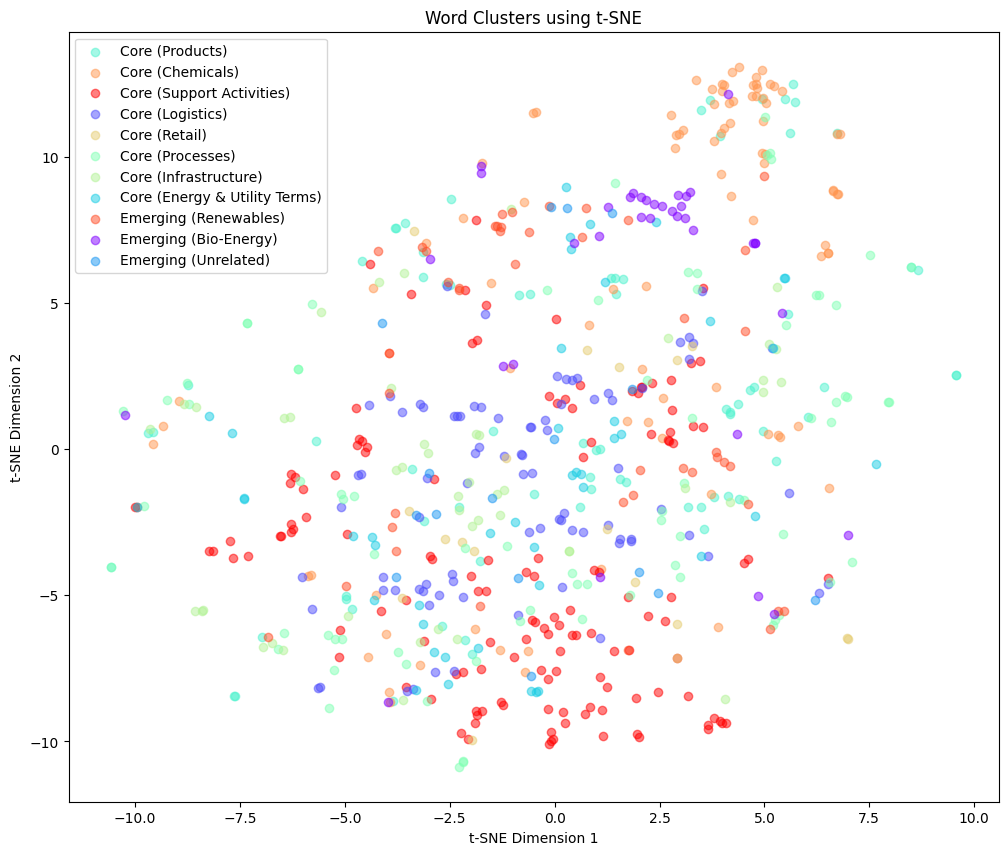

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE to the embeddings
tsne_model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=300)
tsne_results = tsne_model.fit_transform(word_embeddings)

# Prepare colors for each cluster
unique_labels = list(set(labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
label_color_dict = dict(zip(unique_labels, colors))

# Plotting
plt.figure(figsize=(12, 10))
for i, label in enumerate(labels):
    plt.scatter(tsne_results[i, 0], tsne_results[i, 1], color=label_color_dict[label], label=label, alpha=0.5)

# Create a legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removing duplicates in legend
plt.legend(by_label.values(), by_label.keys())

plt.title('Word Clusters using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [5]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import plotly.express as px

# Perform PCA for dimensionality reduction to 3 components
pca = PCA(n_components=3)
pca_results = pca.fit_transform(word_embeddings)


unique_labels = list(set(labels))  
colors = px.colors.qualitative.Plotly 

fig = go.Figure()
for i, label in enumerate(unique_labels):
    indices = [index for index, val in enumerate(labels) if val == label]
    fig.add_trace(go.Scatter3d(
        x=pca_results[indices, 0],
        y=pca_results[indices, 1],
        z=pca_results[indices, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=colors[i % len(colors)],  
        ),
        name=label  
    ))

fig.update_layout(
    title="3D Visualization of Word Clusters",
    scene=dict(
        xaxis_title='PCA Dimension 1',
        yaxis_title='PCA Dimension 2',
        zaxis_title='PCA Dimension 3'
    ),
    legend_title="Cluster",
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


In [6]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Assume 'word_embeddings' and 'labels' are already available

# Perform PCA for 2D reduction
pca = PCA(n_components=2)
pca_results = pca.fit_transform(word_embeddings)

# Get unique cluster names
unique_labels = list(set(labels))

# Create a dictionary to hold checkbox widgets for each cluster
checkboxes = {label: widgets.Checkbox(value=False, description=label) for label in unique_labels}
update_button = widgets.Button(description="Update Plot")
clear_button = widgets.Button(description="Clear Plot")

# Output widget to hold the plot
output = widgets.Output()

# Function to update the plot based on selected clusters
def on_update_button_clicked(b):
    with output:
        clear_output(wait=True)  # Clear the existing plot output properly
        selected_labels = [label for label, checkbox in checkboxes.items() if checkbox.value]
        fig = go.Figure()
        for label in selected_labels:
            indices = [i for i, l in enumerate(labels) if l == label]
            fig.add_trace(go.Scatter(
                x=pca_results[indices, 0],
                y=pca_results[indices, 1],
                mode='markers',
                marker=dict(size=5),
                name=label
            ))
        
        fig.update_layout(
            title="2D Visualization of Selected Clusters",
            xaxis_title='PCA Dimension 1',
            yaxis_title='PCA Dimension 2',
            legend_title="Cluster",
            margin=dict(l=0, r=0, b=0, t=30)
        )
        fig.show()

# Function to clear the plot output
def on_clear_button_clicked(b):
    with output:
        clear_output(wait=True)  # Ensure the output widget is cleared completely

# Set up the button events
update_button.on_click(on_update_button_clicked)
clear_button.on_click(on_clear_button_clicked)

# Display checkboxes and buttons
controls = widgets.VBox([widgets.Label("Select Clusters to Display:")] + list(checkboxes.values()) + [update_button, clear_button])
display(controls, output)


Output()

In [7]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Assume 'word_embeddings' and 'labels' are already available

# Perform PCA for 3D reduction
pca = PCA(n_components=3)
pca_results = pca.fit_transform(word_embeddings)

# Get unique cluster names
unique_labels = list(set(labels))

# Create a dictionary to hold checkbox widgets for each cluster
checkboxes = {label: widgets.Checkbox(value=False, description=label) for label in unique_labels}
update_button = widgets.Button(description="Update Plot")
clear_button = widgets.Button(description="Clear Plot")

# Output widget to hold the plot
output = widgets.Output()

# Function to update the plot based on selected clusters
def on_update_button_clicked(b):
    selected_labels = [label for label, checkbox in checkboxes.items() if checkbox.value]
    fig = go.Figure()
    for label in selected_labels:
        indices = [i for i, l in enumerate(labels) if l == label]
        fig.add_trace(go.Scatter3d(
            x=pca_results[indices, 0],
            y=pca_results[indices, 1],
            z=pca_results[indices, 2],
            mode='markers',
            marker=dict(size=5),
            name=label
        ))

    fig.update_layout(
        title="3D Visualization of Selected Clusters",
        scene=dict(
            xaxis_title='PCA Dimension 1',
            yaxis_title='PCA Dimension 2',
            zaxis_title='PCA Dimension 3'
        ),
        legend_title="Cluster",
        margin=dict(l=0, r=0, b=0, t=30)
    )
    with output:
        clear_output(wait=True)  # Ensure clearing happens here
        fig.show()

# Function to clear the plot output
def on_clear_button_clicked(b):
    with output:
        clear_output(wait=True)  # This should effectively clear the plot

# Set up the button events
update_button.on_click(on_update_button_clicked)
clear_button.on_click(on_clear_button_clicked)

# Display checkboxes and buttons
controls = widgets.VBox([widgets.Label("Select Clusters to Display:")] + list(checkboxes.values()) + [update_button, clear_button])
display(controls, output)


Output()